# Long only breakout and mean reversion strategy
- 

## Set up

Set up the parameters used in in this strategy backtest study.

- Backtested blockchain, exchange and trading pair
- Backtesting period
- Strategy parameters for EMA crossovers

In [ ]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

### Load data

In [ ]:
# Binance data 
import datetime
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.utils.binance import create_binance_universe

# Backtest range
START_AT = datetime.datetime(2019, 1, 1)
END_AT = datetime.datetime(2024, 2, 10)

START_AT_DATA = START_AT - datetime.timedelta(days=120) #This is only for Binance data

strategy_universe = create_binance_universe(
    ["ETHUSDT"],
    candle_time_bucket = TimeBucket.h1,
    stop_loss_time_bucket = TimeBucket.h1,
    start_at = START_AT_DATA,
    end_at = END_AT,
    include_lending=False
)

### Show loaded trading universe



In [ ]:
pairs = strategy_universe.data_universe.pairs  # Trading pairs metadata
candles = strategy_universe.data_universe.candles  # Candles for all trading pairs

print(f"Loaded {candles.get_candle_count():,} candles.")

for pair in pairs.iterate_pairs():
    pair_candles = candles.get_candles_by_pair(pair)
    first_close = pair_candles.iloc[0]["close"]
    first_close_at = pair_candles.index[0]
    print(f"Pair {pair} first close price {first_close} at {first_close_at}")

In [19]:
import datetime
import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.lending import LendingProtocolType  # NEW
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import StrategyType, TradeRouting, ReserveCurrency


# Which trading pair we are backtesting on
TRADING_PAIR = (ChainId.polygon, "uniswap-v3", "WETH", "USDC", 0.0005)

# Which lending reserves we are using for supplying/borrowing assets
# NEW
LENDING_RESERVES = [
   (ChainId.polygon, LendingProtocolType.aave_v3, "WETH"),
   (ChainId.polygon, LendingProtocolType.aave_v3, "USDC.e"),
]


class BacktestParameters:
   # TRADE_ROUTING = TradeRouting.uniswap_v3_usdc
   # RESERVE_CURRENCY = ReserveCurrency.usdc
   
   trading_strategy_cycle = CycleDuration.cycle_1h
   position_size = 0.8
   initial_deposit = 50_000
   lookback_window = 200

   # ATR multiplier for stop loss                   
   atrmult = 2.0

   ema_candle_count = 20  

   rsi_length = 14
   rsi_threshold = 40
   rsi_threshold_short = 52

   backtest_start = datetime.datetime(2019, 1, 1)
   backtest_end = datetime.datetime(2024, 2, 10)

   trailing_stop_loss_pct = 0.995
   trailing_stop_loss_activation_level = 1.008
   take_profit_pct = 1.05
   leverage = 2


class Parameters:
   # TRADE_ROUTING = TradeRouting.uniswap_v3_usdc
   # RESERVE_CURRENCY = ReserveCurrency.usdc
   
   trading_strategy_cycle = CycleDuration.cycle_1h
   position_size = 0.8
   initial_deposit = 50_000
   lookback_window = 200

   # ATR multiplier for stop loss                   
   atrmult = 2.0

   ema_candle_count = 20  

   rsi_length = [14, 20]
   rsi_threshold = [40, 50]
   # rsi_threshold_short = 52

   backtest_start = datetime.datetime(2019, 1, 1)
   backtest_end = datetime.datetime(2024, 2, 10)

   trailing_stop_loss_pct = 0.995
   trailing_stop_loss_activation_level = 1.008
   take_profit_pct = 1.05
   leverage = 2

## Strategy logic and trade decisions

- `decide_trades` function decide what trades to take.
- In this example, we calculate two exponential moving averages
(EMAs) and make decisions based on those.

### Indicators

- Note how we also make use of detached and overlayed technical indicators, so that the price chart is not overcrowded

In [ ]:
from typing import List, Dict

from pandas_ta import bbands
from pandas_ta.volatility import atr
from pandas_ta.overlap import ema
from pandas_ta.momentum import rsi

from tradingstrategy.universe import Universe
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse

from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager


def decide_trades(
    timestamp: pd.Timestamp,
    strategy_universe: TradingStrategyUniverse,
    state: State,
    pricing_model: PricingModel,
    cycle_debug_data: Dict
)-> List[TradeExecution]:
  
    # Resolve some variables we are going to use to here
    parameters: Parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    universe = input.strategy_universe.universe
    indicators = input.indicators
    universe = strategy_universe.universe
    pair = universe.pairs.get_single()
    cash = state.portfolio.get_current_cash()
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=parameters.lookback_window)
    close_prices = candles["close"]

    # Calculate exponential moving for candle close
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/overlap/help/pandas_ta.overlap.ema.html#ema
    moving_average = ema(close_prices, length=EMA_CANDLE_COUNT)
    trend_ema = ema(close_prices, length=20)
    
    # trend_moving_average = ema(close_prices, length=TREND_EMA_CANDLE_COUNT)
    
    # Calculate RSI for candle close
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/momentum/help/pandas_ta.momentum.rsi.html#rsi
    current_rsi = rsi(close_prices, length=RSI_LENGTH)[-1]

    trades = []

    if moving_average is None or trend_ema is None:
        # Cannot calculate EMA, because
        # not enough samples in backtesting buffer yet.
        return trades
    

    price_close = close_prices.iloc[-1]
    previous_high = candles["high"].iloc[-2]

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, strategy_universe, state, pricing_model)

    # Calculate wider Bollinger Bands using the typical 20-day SMA and 2 standard deviations 
    bollinger_bands_wide = bbands(close_prices, length=20, std=2)
    wide_bb_upper = bollinger_bands_wide["BBU_20_2.0"]
    wide_bb_lower = bollinger_bands_wide["BBL_20_2.0"]

    # Initialize variables
    highest20 = 0 
    previous_highest20 = 0
    stoploss_price_long = None
    bb_trade = None
    breakout_trade = None


    # Calculate ATR based stop loss 
    atr_stop = atr(candles["high"], candles["low"], close_prices, length=14).iloc[-1] * ATRmult

    # Iterate over the data to find the highest price in the last 20 candles
    for i in range(len(candles)):
        if i >= 9:  # Ensure there are at least 20 candles to look back
            # Calculate the highest high of the past 20 candles excluding the latest candle
            if i < len(candles) - 1:  # Exclude the latest candle
                previous_highest20 = candles['high'][i-9:i+1].max()

            # Calculate the highest high of the past 20 candles including the latest candle
            highest20 = candles['high'][i-8:i+2].max()  # Highest price in the past 20 candles
    
    ### LONGING
    if not position_manager.is_any_long_position_open():
        # Open long positions based on trading logic
        bb_trade = False
        breakout_trade = False
    
        # Bollinger Bands Trade Entry Logic
        if (price_close < wide_bb_lower.iloc[-1]) and (current_rsi < RSI_THRESHOLD): # and (price_close > (1.01 * trend_ema.iloc[-1])):
            amount = cash * POSITION_SIZE
            entry_price = price_close
            STOP_LOSS = entry_price - atr_stop
            bb_trade = True
            new_trades = position_manager.open_1x_long(pair, amount, stop_loss_usd=STOP_LOSS, take_profit_pct=TAKE_PROFIT_PCT)
            trades.extend(new_trades)
        
        # Breakout Trade Entry Logic
        if (price_close > previous_highest20) and (close_prices.iloc[-2] < previous_highest20) and (price_close > trend_ema.iloc[-1]) and (current_rsi > 50):
            amount = cash * POSITION_SIZE
            entry_price = price_close
            STOP_LOSS = entry_price - atr_stop
            #breakout_trade = True
            new_trades = position_manager.open_1x_long(pair, amount, stop_loss_usd=STOP_LOSS, take_profit_pct=TAKE_PROFIT_PCT)
            trades.extend(new_trades)

    else:
        # Manage open long positions
        current_position = position_manager.get_current_long_position()
        stoploss_price_long = current_position.stop_loss

        # Bollinger Bands Trade Exit Logic
        if bb_trade and (price_close > wide_bb_upper.iloc[-1]) and (close_prices.iloc[-2] < wide_bb_upper.iloc[-2]):
            new_trades = position_manager.close_position(current_position)
            trades.extend(new_trades)
            bb_trade = False

        # Breakout Trade Exit Logic
        if price_close > (TRAILING_STOP_LOSS_ACTIVATION_LEVEL * current_position.get_opening_price()):

            current_position.trailing_stop_loss_pct = TRAILING_STOP_LOSS_PCT
            stoploss_price_long = current_position.stop_loss
            if current_position.stop_loss <= float(price_close * TRAILING_STOP_LOSS_PCT):   # Move the trailing stop loss level only of the new value is higher
                current_position.stop_loss = float(price_close * TRAILING_STOP_LOSS_PCT)
                stoploss_price_long = current_position.stop_loss

            if price_close > wide_bb_upper.iloc[-1]:
                new_trades = position_manager.close_position(current_position)
                trades.extend(new_trades)
    
            #breakout_trade = False

            #current_position.trailing_stop_loss_pct = TRAILING_STOP_LOSS_PCT
            #stoploss_price_long = position_manager.get_current_long_position().stop_loss
            #if current_position.stop_loss <= float(price_close * TRAILING_STOP_LOSS_PCT):
            #    current_position.stop_loss = float(price_close * TRAILING_STOP_LOSS_PCT)
            #    stoploss_price_long = current_position.stop_loss
            #breakout_trade = False


        
    # Visualise our technical indicators
    visualisation = state.visualisation
    visualisation.plot_indicator(timestamp, "Wide BB upper", PlotKind.technical_indicator_on_price, wide_bb_upper.iloc[-1], colour="red")
    visualisation.plot_indicator(timestamp, "Wide BB lower", PlotKind.technical_indicator_on_price, wide_bb_lower.iloc[-1], colour="red")
    visualisation.plot_indicator(timestamp, "Highest 20", PlotKind.technical_indicator_on_price, previous_highest20, colour="orange")
    visualisation.plot_indicator(timestamp, "Stop Loss", PlotKind.technical_indicator_on_price, stoploss_price_long, colour="purple")    
    visualisation.plot_indicator(timestamp, "EMA", PlotKind.technical_indicator_on_price, moving_average.iloc[-1], colour="black")
    visualisation.plot_indicator(timestamp, "Trend EMA", PlotKind.technical_indicator_on_price, trend_ema.iloc[-1], colour="grey")
    visualisation.plot_indicator(timestamp, "RSI", PlotKind.technical_indicator_detached, current_rsi)
    visualisation.plot_indicator(timestamp, "RSI Threshold", PlotKind.technical_indicator_overlay_on_detached, RSI_THRESHOLD, detached_overlay_name="RSI")
    visualisation.plot_indicator(timestamp, "RSI Short Threshold", PlotKind.technical_indicator_overlay_on_detached, RSI_THRESHOLD_SHORT, detached_overlay_name="RSI")


    return trades

## Defining the trading universe

We create a trading universe with a single blockchain, single exchange and a single trading pair.

Trading Strategy framework supports complex strategies, spanning thousands of pairs and lending pools,
but we are not interested in this example.

In [ ]:
import datetime
from tradingstrategy.client import Client
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions


def create_single_pair_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    dataset = load_partial_data(
        client,
        execution_context=execution_context,
        time_bucket=CANDLE_TIME_BUCKET,
        pairs=[TRADING_PAIR],
        universe_options=universe_options,
        start_at=universe_options.start_at,
        end_at=universe_options.end_at,
        lending_reserves=LENDING_RESERVES, 
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
    )

    # Filter down to the single pair we are interested in
    strategy_universe = TradingStrategyUniverse.create_single_pair_universe(dataset)

    return strategy_universe

## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [ ]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /home/alex/.tradingstrategy


## Load data

In [ ]:
from datetime import timedelta
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradingstrategy.utils.groupeduniverse import fix_bad_wicks

# universe = create_single_pair_trading_universe(
#     END_AT,
#     client,
#     ExecutionContext(mode=ExecutionMode.data_preload),
#     UniverseOptions(
#         # NOTE: quick hack to get enough data for look back period
#         start_at=START_AT - timedelta(days=50),
#         end_at=END_AT,
#     )
# )

# fix_bad_wicks(universe.universe.candles.df)


print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

Loading OHLCV data for 1 pairs:   0%|          | 0/14860800 [00:00<?, ?it/s]

We loaded 4,125 candles.


## Run backtest

Run backtest using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.
- The trade execution engine will download the necessary datasets to run the backtest.
  The datasets may be large, several gigabytes.

In [ ]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, debug_dump = run_backtest_inline(
    name="BB long short mean reversion strategy",
    start_at=START_AT,
    end_at=END_AT,
    client=client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
    engine_version="0.3",
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/10540800 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 265 trades


## Examine backtest results

Examine `state` that contains all actions the trade executor took.

We plot out a chart that shows
- The price action
- When the strategy made buys or sells

In [ ]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 133
Trades made: 265


In [ ]:

from tradeexecutor.visual.single_pair import visualise_single_pair, visualise_single_pair_positions_with_duration_and_slippage
from tradingstrategy.charting.candle_chart import VolumeBarMode

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    start_at=START_AT,
    end_at=END_AT,
    #volume_bar_mode=VolumeBarMode.separate,
    #volume_axis_name="Volume (USD)",
    height = 1100,
)

figure.show()

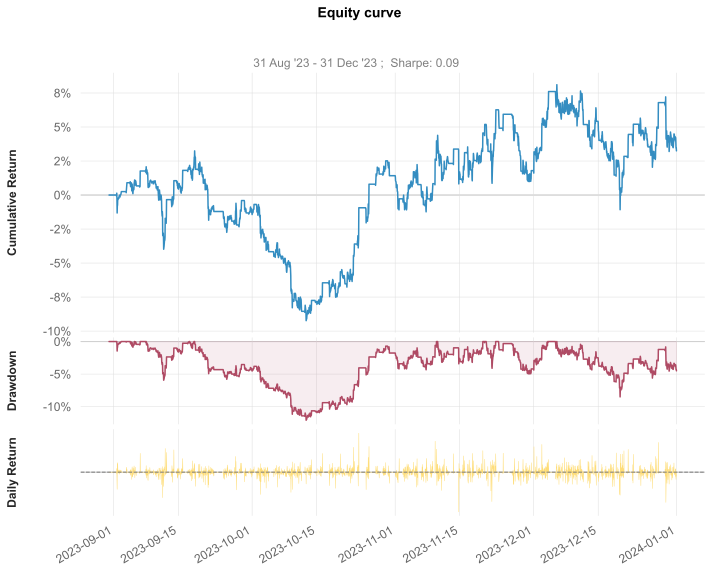

In [ ]:
from tradeexecutor.utils.notebook import setup_charting_and_output
setup_charting_and_output()


# Needed to improve the resolution of matplotlib chart used here
%config InlineBackend.figure_format = 'svg'

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
visualise_equity_curve(returns)

## Benchmarking the strategy performance

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold the underlying trading pair base asset

In [ ]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    "BB long short mean reversion strategy - Own data",
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=START_AT,
    end_at=END_AT,
    height=700
)

fig.show()

/tmp/ipykernel_439417/3699903756.py:5: DeprecationWarning:

This function is deprecated. Use visualise_equity_curve_benchmark instead



## Analysing  the strategy success

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance

In [ ]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Strategy summary

Overview of strategy performance


In [ ]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics(state=state, time_bucket = CANDLE_TIME_BUCKET)

# with pd.option_context("display.max_row", None):
#      display(summary.to_dataframe())

summary.display()

/home/alex/.cache/pypoetry/virtualenvs/trade-executor-xSh0vQvh-py3.10/lib/python3.10/site-packages/quantstats/stats.py:968: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



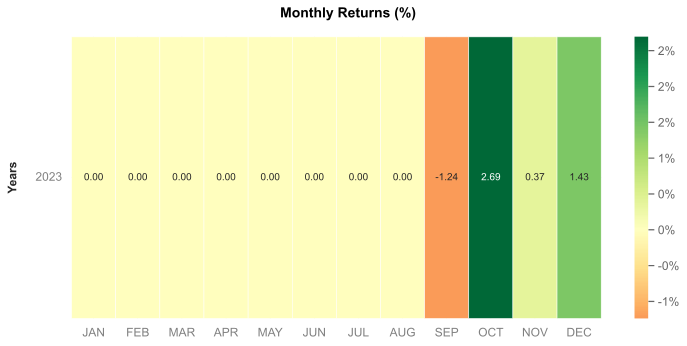

In [ ]:
from tradeexecutor.visual.equity_curve import visualise_returns_over_time

visualise_returns_over_time(returns)

In [ ]:
from IPython.core.display_functions import display

summary_by_side = analysis.calculate_all_summary_stats_by_side(state=state, time_bucket=CANDLE_TIME_BUCKET)

display(summary_by_side)

All  \
Trading period length                          122 days 0 hours   
Return %                                                  3.25%   
Annualised return %                                       9.72%   
Cash at start                                        $50,000.00   
Value at end                                         $51,625.08   
Trade volume                                     $10,693,705.85   
Position win percent                                     53.79%   
Total positions                                             132   
Won positions                                                71   
Lost positions                                               61   
Stop losses triggered                                        79   
Stop loss % of all                                       59.85%   
Stop loss % of lost                                     129.51%   
Winning stop losses                                          18   
Winning stop losses percent                              22.78%   
Losing stop losses                                           61   
Losing stop losses percent                               77.22%   
Take profits triggered                                        0   
Take profit % of all                                      0.00%   
Take profit % of won                                      0.00%   
Zero profit positions                                         0   
Positions open at the end                                     1   
Realised profit and loss                              $2,126.60   
Unrealised profit and loss                             $-501.52   
Portfolio unrealised value                           $41,199.76   
Extra returns on lending pool interest                    $0.00   
Cash left at the end                                 $10,425.32   
Average winning position profit %                         1.34%   
Average losing position loss %                           -1.45%   
Biggest winning position %                                4.85%   
Biggest losing position %                                -3.41%   
Average duration of winning positions       12 hours 16 minutes   
Average duration of losing positions         13 hours 9 minutes   
Average duration between position openings  23 hours 56 minutes   
Average positions per day                                  1.08   
Average interest paid                                     $0.00   
Median interest paid                                      $0.00   
Total interest paid                                       $0.00   
Average bars of winning positions                       12 bars   
Average bars of losing positions                        13 bars   
LP fees paid                                          $5,348.19   
LP fees paid % of volume                                  0.05%   
Average position                                          0.05%   
Median position                                           0.41%   
Most consecutive wins                                         8   
Most consecutive losses                                       9   
Biggest realised risk                                    -2.73%   
Avg realised risk                                        -1.16%   
Max pullback of total capital                            -8.20%   
Max loss risk at opening of position                      3.51%   
Max drawdown                                            -12.08%   

                                                           Long  \
Trading period length                                         -   
Return %                                                  3.25%   
Annualised return %                                       9.72%   
Cash at start                                                 -   
Value at end                                                  -   
Trade volume                                     $10,693,705.85   
Position win percent                                     53.79%   
Total positions                        

In [ ]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics, AdvancedMetricsMode

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
metrics = visualise_advanced_metrics(returns, mode=AdvancedMetricsMode.full)

with pd.option_context("display.max_row", None):
    display(metrics)

Strategy
Start Period               2023-09-01
End Period                 2023-12-31
Risk-Free Rate                   0.0%
Time in Market                  62.0%
Cumulative Return               3.25%
CAGR﹪                          10.13%
Sharpe                            0.1
Prob. Sharpe Ratio             61.55%
Smart Sharpe                      0.1
Sortino                          0.15
Smart Sortino                    0.15
Sortino/√2                       0.11
Smart Sortino/√2                 0.11
Omega                            1.02
Max Drawdown                  -12.08%
Longest DD Days                    52
Volatility (ann.)                5.1%
Calmar                           0.84
Skew                              0.4
Kurtosis                        13.29
Expected Daily                   0.0%
Expected Monthly                 0.8%
Expected Yearly                 3.25%
Kelly Criterion                 0.98%
Risk of Ruin                     0.0%
Daily Value-at-Risk            -0.44%
Expected Shortfall (cVaR)      -0.44%
Max Consecutive Wins                8
Max Consecutive Losses              7
Gain/Pain Ratio                  0.08
Gain/Pain (1M)                   3.93
Payoff Ratio                     1.15
Profit Factor                    1.02
Common Sense Ratio               1.08
CPC Index                        0.55
Tail Ratio                       1.06
Outlier Win Ratio                9.06
Outlier Loss Ratio               3.85
MTD                             1.43%
3M                              4.62%
6M                              3.25%
YTD                             3.25%
1Y                              3.25%
3Y (ann.)                      10.13%
5Y (ann.)                      10.13%
10Y (ann.)                     10.13%
All-time (ann.)                10.13%
Best Day                        2.35%
Worst Day                       -2.4%
Best Month                      2.69%
Worst Month                    -1.24%
Best Year                       3.25%
Worst Year                      3.25%
Avg. Drawdown                  -2.18%
Avg. Drawdown Days                  5
Recovery Factor                  0.27
Ulcer Index                      0.05
Serenity Index                   0.02
Avg. Up Month                    1.5%
Avg. Down Month                -1.24%
Win Days                       47.02%
Win Month                       75.0%
Win Quarter                     50.0%
Win Year                       100.0%

### Position and trade timeline

Display all positions and how much profit they made.

In [ ]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))

## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [ ]:
print("All ok")

All ok
